# Problem Statement: #

HELP International have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. So, CEO has to make decision to choose the countries that are in the direst need of aid. Hence, your Job as a Data scientist is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.

In [124]:
# import libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None) 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler


from  matplotlib.ticker import PercentFormatter #for formatting the y axis on plots into percentages

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(rows=2)

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

In [80]:
# Import datasets

ds = pd.read_csv("Country-data.csv")
dd = pd.read_csv("data-dictionary.csv")

# Data Dictionary

In [81]:
dd.head(10)

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 1000 live births
2,exports,Exports of goods and services per capita. Given as %age of the GDP per capita
3,health,Total health spending per capita. Given as %age of GDP per capita
4,imports,Imports of goods and services per capita. Given as %age of the GDP per capita
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of the Total GDP
7,life_expec,The average number of years a new born child would live if the current mortality patterns are to remain the same
8,total_fer,The number of children that would be born to each woman if the current age-fertility rates remain the same.
9,gdpp,The GDP per capita. Calculated as the Total GDP divided by the total population.


# Exploratory Data Analysis

In [82]:
ds.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [83]:
# Check for null values
ds.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [84]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [85]:
ds.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


The above table gives some of the following insights:
- Average child mortality/1000 is 38 children, the maximum is a whopping 208!
- An average of 6% of the GDPP is spent on health, the maximum spent is 17.9%
- Average income per person is 46 and the maximum 125000, huge disparity here.
- Average inflation rate is close to 8 percent, the maximum is 104 percent

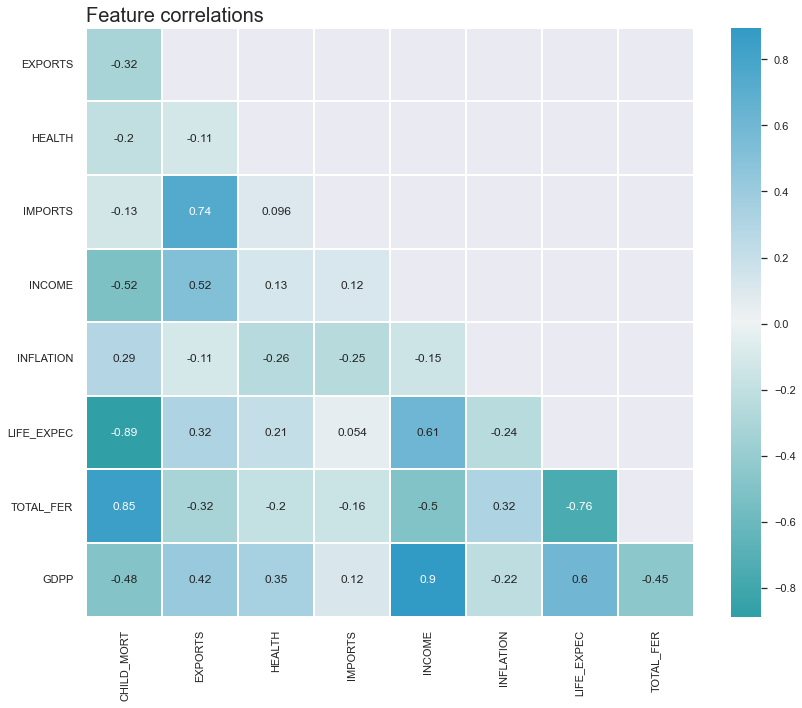

In [86]:
#Plot correlation matrix

plt.rcParams["figure.figsize"] = [12, 10]
plt.rcParams["figure.autolayout"] = True

#create a mask to show only only the upper triangle

cors = np.ones_like(ds.corr(), dtype=bool)
mask = np.triu(cors)

# adjust mask and df to ommit the empty cells
mask = mask[1:, :-1]
df_corr = ds.corr().iloc[1:,:-1]

#Create diverging palette
cmap = sns.diverging_palette(200, 230, 90, 60, as_cmap=True)

sns.heatmap(df_corr, annot=True, cmap=cmap, linewidth=0.4, mask=mask)
plt.title("Feature correlations", loc="left", fontsize = 20)
yticks = [i.upper() for i in df_corr.index]
xticks = [i.upper() for i in df_corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks,rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks, rotation=90)
plt.show()

We can see the following from the correlation heatmap:


 - As expected GDPP and income are highly correlated. 
 - Number of children born per woman is highly correlated with child mortality, which makes sense. 
 - Imports and exports are highly correlated as expected. 
 - Life expectancy is highly negatively correlated with child mortality. 
 - Life expenctancy is correlated with income
 - Life expectancy is correlated with GDPP
 
 We can safely drop life expectancy, total fertility and income as they are all very highly correlated to other features

In [125]:
#Drop the correlated features and the country feature


ds_numeric = ds.drop(columns = ['income', 'country', 'life_expec', 'total_fer'])


#Scale the data

scaler = StandardScaler()
ds_scaled = scaler.fit_transform(ds_numeric)

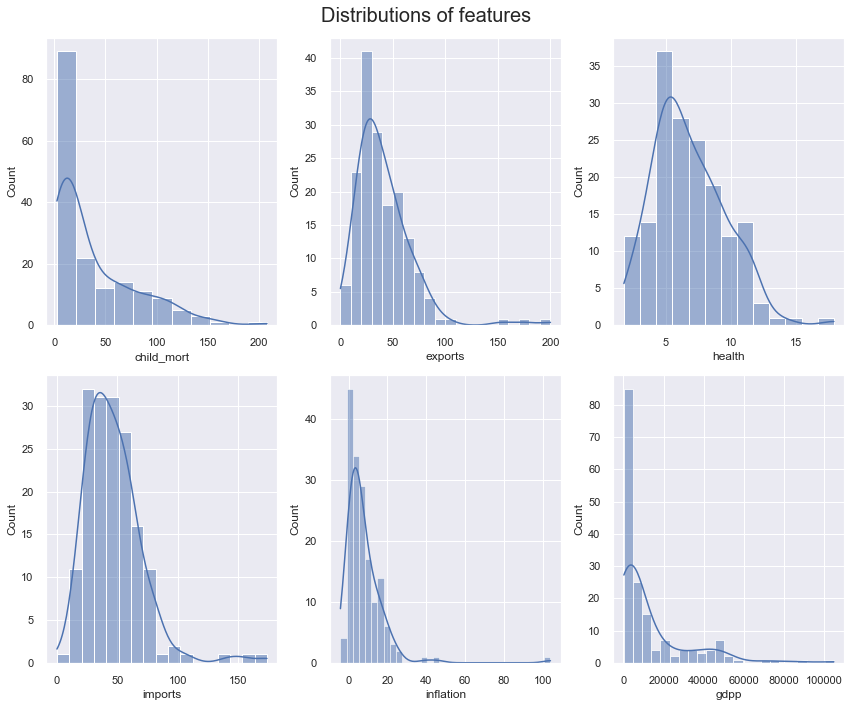

In [88]:
#plot some graphs to check feature distributions

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,10))
ax = ax.flatten() #allows axes to be looped over
plt.suptitle("Distributions of features", fontsize=20)
for x, i in enumerate(ds_numeric.columns):
    sns.histplot(ds_numeric[i], ax = ax[x], kde=True, palette="Blues")


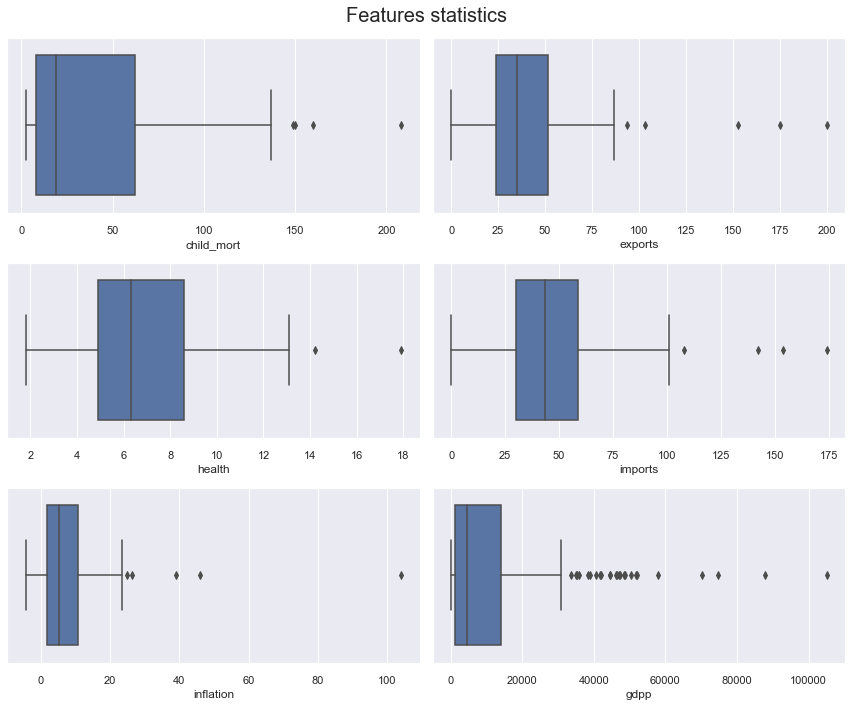

In [89]:
# Create box and whisper plots to check for range, outliers and quartiles

fig, ax = plt.subplots(nrows=3, ncols=2)
plt.suptitle("Features statistics", fontsize=20)
ax = ax.flatten()
for x, i in enumerate(ds_numeric.columns):
    sns.boxplot(x=ds_numeric[i], ax=ax[x])

GDPP, inflation, income, imports and exports have many outliers. We cannot change these as these are actually values for the country and dropping them or changing them would change the message from the data.

In [126]:
#Plot child mortality rates
fig=px.choropleth(data_frame=ds, 
                  locationmode='country names', 
                  locations='country', 
                  color='child_mort', 
                  title='Child Mortality rate by countries',
                  color_continuous_scale="Teal")
fig.update_geos(showocean=True, 
                oceancolor="LightBlue",
                projection_type="natural earth")
fig.show()

In [91]:
# Plot health data

fig = px.choropleth(data_frame=ds,
                   locationmode="country names",
                   locations="country",
                   color="health",
                   title = "Health Spending per country",
                   color_continuous_scale="Teal")
fig.update_geos(showocean=True,
               oceancolor="LightBlue",
               projection_type="natural earth")

In [127]:
#Plot exports
fig = px.choropleth(data_frame=ds,
                   locationmode="country names",
                    locations="country",
                   color = "exports",
                   title="Exports by country",
                   color_continuous_scale="Teal")
fig.update_geos(showocean=True,
               oceancolor='LightBlue',
               projection_type="natural earth")
fig.show()

In [93]:
fig = px.choropleth(data_frame=ds,
                  locations="country",
                  locationmode = "country names",
                  title="Inflation rate per capita by country",
                  color="inflation",
                  color_continuous_scale="Teal")
fig.update_geos(showocean=True,
          oceancolor="LightBlue",
          projection_type = "natural earth")
fig.show()

In [94]:
fig = px.choropleth(data_frame= ds,
                   locations = "country",
                   color = "imports",
                   locationmode="country names", 
                   color_continuous_scale="Teal",
                   title="Imports per capita by country")
fig.update_geos(showocean=True,
               oceancolor="LightBlue",
               projection_type='natural earth')

In [95]:
fig = px.choropleth(data_frame=ds,
                   locations="country",
                   locationmode="country names",
                   color="income", 
                   color_continuous_scale="Teal",
                   title = "Income  by country")
fig.update_geos(showocean=True,
               oceancolor="LightBlue",
               projection_type='natural earth')

In [96]:
fig = px.choropleth(data_frame=ds,
                   locations="country",
                   locationmode="country names",
                   color="life_expec", 
                   color_continuous_scale="Teal",
                   title = "Life Expectancy by country")
fig.update_geos(showocean=True,
               oceancolor="LightBlue",
               projection_type='natural earth')

In [97]:
fig = px.choropleth(data_frame=ds,
                   locations="country",
                   locationmode="country names",
                   color="total_fer", 
                   color_continuous_scale="Teal",
                   title = "No Children born to each woman by country")
fig.update_geos(showocean=True,
               oceancolor="LightBlue",
               projection_type='natural earth')

In [98]:
fig = px.choropleth(data_frame=ds,
                   locations="country",
                   locationmode="country names",
                   color="gdpp", 
                   color_continuous_scale="Teal",
                   title = "GDP by country")
fig.update_geos(showocean=True,
               oceancolor="LightBlue",
               projection_type='natural earth')

# K Means


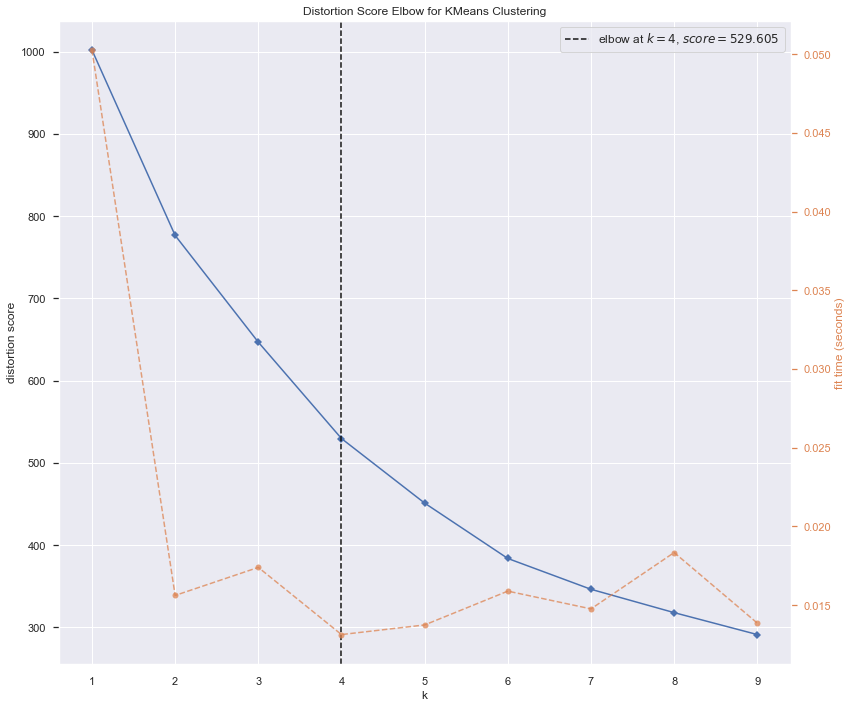

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [99]:
# Visualise the elbow method with the scaled data.
model = KMeans()
visualize = KElbowVisualizer(model, k=(1,10))
visualize.fit(ds_scaled)
visualize.poof()

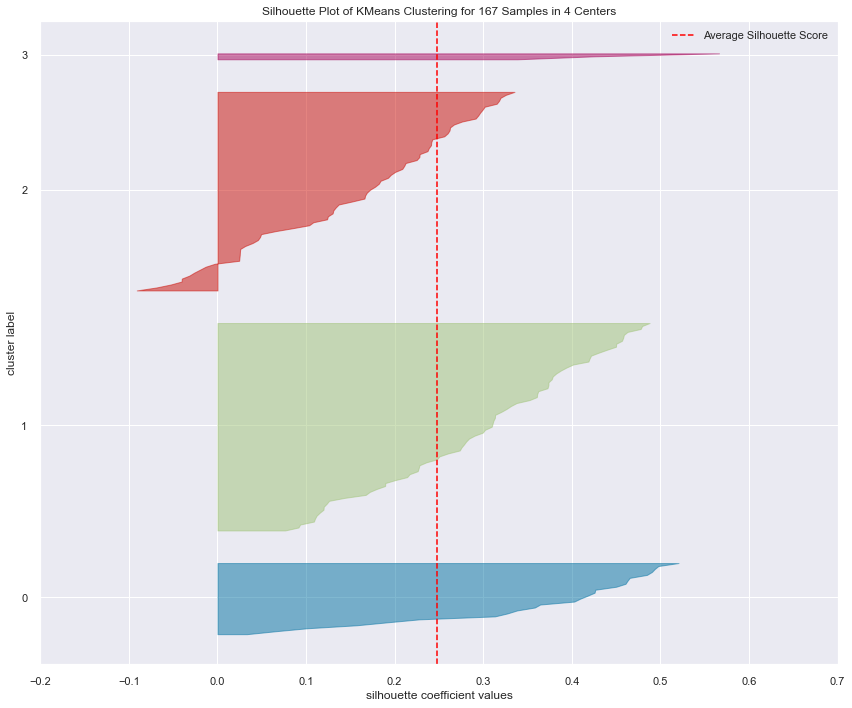

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 167 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [100]:
# Create a silhouette graph for 4 clusters
model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(ds_scaled)        # Fit the data to the visualizer
visualizer.show()

Run the model with 4 clusters:

In [130]:
model = KMeans(n_clusters=4, random_state=123)
model.fit(ds_numeric)

KMeans(n_clusters=4, random_state=123)

In [132]:
# Add a new column to the original dataset
ds['Cluster'] = model.labels_
ds.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,3


In [103]:
ds.Cluster.unique()

array([1, 3, 0, 2], dtype=int32)

In [104]:
ds.Cluster.value_counts()

1    110
3     29
0     24
2      4
Name: Cluster, dtype: int64

In [105]:
# Show the means of each feature from the describe function
clst_av = ds.describe().iloc[1:2]
clst_av

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
mean,38.27006,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689,1.227545


In [106]:
#check the average values for each cluster.

clusters = ds.groupby(['Cluster']).mean()
clusters

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
Cluster,,,,,,,,,
0,4.983333,51.795833,9.107917,45.137500,44658.333333,2.728500,80.479167,1.825000,42458.333333
1,53.342727,34.043627,6.254364,45.873326,6669.663636,9.235764,66.650909,3.497091,3110.127273
2,4.875000,85.250000,7.640000,61.900000,83625.000000,4.216750,81.000000,1.792500,84425.000000
3,13.251724,52.975862,6.934138,50.127586,24937.931034,6.940724,75.713793,1.953793,16075.862069


In [108]:
checkclt = clusters.copy()

#create a dataframe to compare each feature and cluster around the average for each cluster

for i in range(0,4):
    for col in checkclt.columns:
        if checkclt[col][i]>=clst_av[col][0]:
            checkclt[col][i] = "Above"
        else:
            checkclt[col][i] = "Below"

checkclt

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
Cluster,,,,,,,,,
0,Below,Above,Above,Below,Above,Below,Above,Below,Above
1,Above,Below,Below,Below,Below,Above,Below,Above,Below
2,Below,Above,Above,Above,Above,Below,Above,Below,Above
3,Below,Above,Above,Above,Above,Below,Above,Below,Above


### Cluster 0:
 
 - Child mortality: Low
 - Exports: Above average
 - Health spending per capita: Above average
 - Imports: Average
 - Income per capita: Above average
 - Inflation: Below average
 - Life expectancy: Above average
 - Fertility: Below average
 - GDPP: Above average
 
    This cluster can be ticked off the list as not needing help 
 
### Cluster 1: 
 
 - Child mortality: VERY high
 - Exports: Below average
 - Health spending per capita: Below average
 - Imports: Average
 - Income per capita: Below average
 - Inflation: Above average
 - Life expectancy: Below average
 - Fertility: Above average
 - GDPP: Above average
 
    This cluster looks like it is a candidate for help
 
### Cluster 2:
 
 - Child mortality: Low Medium
 - Exports: Above average
 - Health spending per capita: Above average
 - Imports: Above average
 - Income per capita: Above average
 - Inflation: Below average
 - Life expectancy: Above average
 - Fertility: Below average
 - GDPP: Above average
 
     This cluster is only a few countries and are not in need of help.
 
### Cluster 3:
 
 - Child mortality: Low
 - Exports: Above average
 - Health spending per capita: Average
 - Imports: Above average
 - Income per capita: Above average
 - Inflation: Below average
 - Life expectancy: Above average
 - Fertility: Below average
 - GDPP: Above average
 
     This cluster would be second in line for help.


In [109]:
# plot the clusters
ds_convert = ds.copy()
cat = {0:'No help needed',1:'Help needed',2:'Unlikely help needed', 3: 'Second in line for help'}
ds_convert['Cluster']=ds_convert['Cluster'].map(cat)

fig = px.choropleth(data_frame=ds_convert,
                   locations="country",
                   locationmode="country names",
                   color="Cluster",
                   title = "Clusters by country",
                   color_discrete_map={'No help needed':'#40E0D0','Help needed':'#DE3163','Unlikely help needed':'#9FE2BF', 'Second in line for help':'#FF7F50'})
fig.update_geos(showocean=True,
               oceancolor="LightBlue",
               projection_type='natural earth')

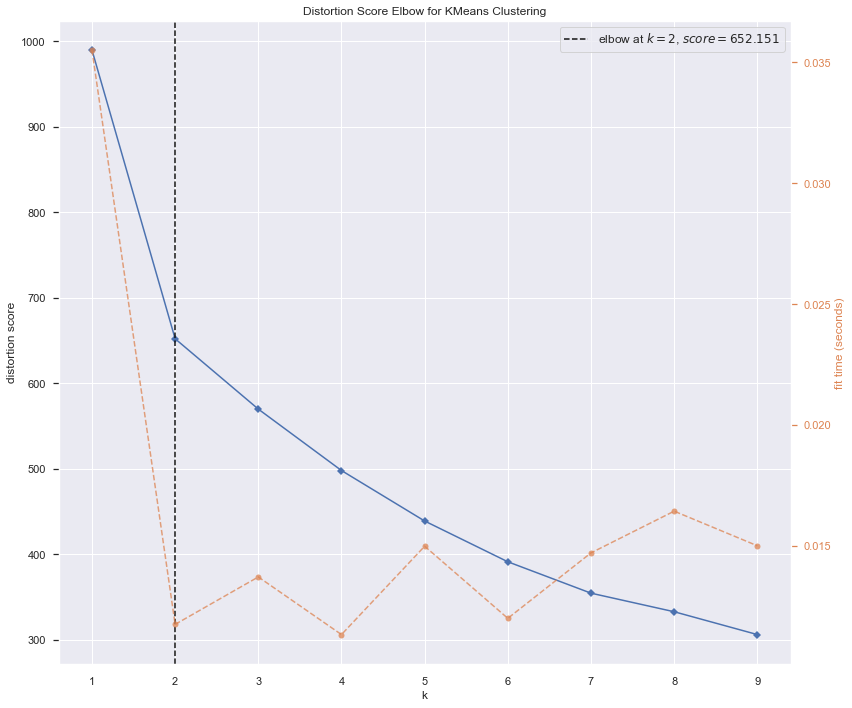

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [110]:
# Now do a cluster analysis on cluster 1, starting by filtering the dataset for cluster 1

cluster1_ds = ds[ds['Cluster']==1]
cluster1_ds_numeric = cluster1_ds.iloc[:,1:]

#Scale the new dataset

cluster1_scaled = scaler.fit_transform(cluster1_ds_numeric)

model = KMeans()
visualize = KElbowVisualizer(model, k=(1,10))
visualize.fit(cluster1_scaled)
visualize.poof()

In [111]:
model2 = KMeans(n_clusters=2, random_state=123)
model2.fit(cluster1_scaled)

KMeans(n_clusters=2, random_state=123)

In [133]:
# Add a sub cluster column to cluster the original cluster 1
cluster1_ds['Cluster_sub'] = model2.labels_
cluster1_ds.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster,Cluster_sub
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1,1
6,Armenia,18.1,20.8,4.40,45.3,6700,7.77,73.3,1.69,3220,1,0


In [113]:
cluster1_ds.groupby(['Cluster_sub']).mean()


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
Cluster_sub,,,,,,,,,,
0,24.955556,40.715873,6.330317,48.936508,9960.000000,7.466175,71.552381,2.452698,4685.968254,1.0
1,91.393617,25.099979,6.152553,41.767360,2259.212766,11.607766,60.080851,4.897021,997.829787,1.0


Cluster 1 has the higher child mortality rate, lower exports, income, life expectancy and GDP, and a higher inflation rate, thus our help must go to one of these countries in this cluster

In [114]:
# plot the clusters
ds_convert = cluster1_ds.copy()
cat = {0:'No help needed',1:'Help needed'}
ds_convert['Cluster_sub']=ds_convert['Cluster_sub'].map(cat)

fig = px.choropleth(data_frame=ds_convert,
                   locations="country",
                   locationmode="country names",
                   color="Cluster_sub",
                   title = "Clusters by country",
                   color_discrete_map={'No help needed':'#40E0D0','Help needed':'#DE3163'})
fig.update_geos(showocean=True,
               oceancolor="LightBlue",
               projection_type='natural earth')

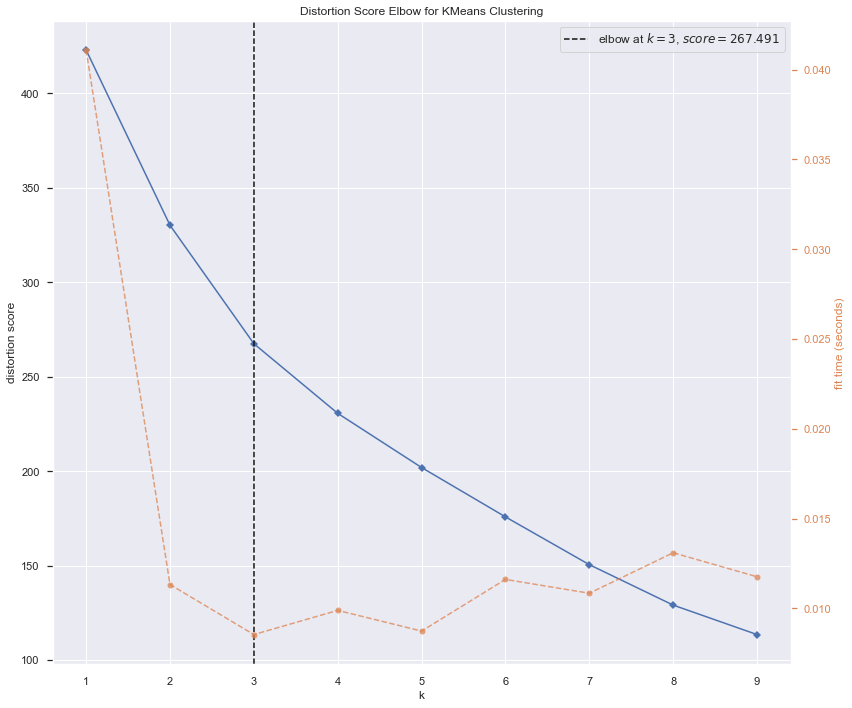

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [134]:
# Lets try and cut down our options by clustering the remaining countries

cluster1_1_ds = cluster1_ds[cluster1_ds['Cluster_sub']==1]
cluster1_1_ds_numeric = cluster1_1_ds.iloc[:,1:]

#Scale the new dataset

cluster1_1_scaled = scaler.fit_transform(cluster1_1_ds_numeric)

model = KMeans()
visualize = KElbowVisualizer(model, k=(1,10))
visualize.fit(cluster1_1_scaled)
visualize.poof()

In [135]:
model3 = KMeans(n_clusters=4, random_state=123)
model3.fit(cluster1_1_scaled)

KMeans(n_clusters=4, random_state=123)

In [136]:
# Add a sub-sub cluster column to cluster the original cluster 1
cluster1_1_ds['Cluster_sub_sub'] = model3.labels_

cluster1_1_ds.groupby(['Cluster_sub_sub']).mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster,Cluster_sub
Cluster_sub_sub,,,,,,,,,,,
0,69.950000,30.275000,10.687500,88.675000,1647.500000,4.487500,57.425000,4.100000,1069.250000,1.0,1.0
1,108.316000,23.652800,6.611200,39.880000,1530.520000,7.556600,56.756000,5.491200,642.640000,1.0,1.0
2,104.300000,57.566667,3.460000,38.333333,5413.333333,49.033333,60.333333,5.650000,2866.666667,1.0,1.0
3,66.326667,19.638600,4.717333,33.091060,3006.000000,12.773333,66.280000,3.968667,1197.000000,1.0,1.0


Cluster one is the most obvious in need of help here, the other 3 are more difficult to differentiate

In [121]:
cluster1_1_ds[cluster1_1_ds['Cluster_sub_sub']==1].country.tolist()

['Afghanistan',
 'Benin',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Comoros',
 'Congo, Dem. Rep.',
 "Cote d'Ivoire",
 'Gambia',
 'Guinea',
 'Guinea-Bissau',
 'Haiti',
 'Madagascar',
 'Malawi',
 'Mali',
 'Mozambique',
 'Niger',
 'Rwanda',
 'Sierra Leone',
 'Tanzania',
 'Togo',
 'Uganda',
 'Zambia']

In [122]:
# plot the clusters
ds_convert = cluster1_1_ds.copy()
cat = {0:'Least help needed',1:'Help needed most',2:'Help needed 2', 3: 'Help needed 3'}
ds_convert['Cluster_sub_sub']=ds_convert['Cluster_sub_sub'].map(cat)

fig = px.choropleth(data_frame=ds_convert,
                   locations="country",
                   locationmode="country names",
                   color="Cluster_sub_sub",
                   title = "Clusters by country",
                   color_discrete_map={'Least help needed':'#40E0D0','Help needed most':'#DE3163','Help needed 2':'#9FE2BF', 'Help needed 3':'#FF7F50'})
fig.update_geos(showocean=True,
               oceancolor="LightBlue",
               projection_type='natural earth')

In [123]:
# Choose top 5 countries with the highest child mortality
child_mort = cluster1_1_ds[cluster1_1_ds['Cluster_sub_sub']==1].sort_values('child_mort', ascending=False).head(4)['country'].tolist()
print(f"Top 5 countries most in need of help with child mortality: {','.join(child_mort)}")

# Choose top 5 countries with the lowest health spending per head
health = cluster1_1_ds[cluster1_1_ds['Cluster_sub_sub']==1].sort_values('child_mort', ascending=True).head(4)['country'].tolist()
print(f"Top 5 countries most in need of help with per capita health spending: {','.join(health)}")

# Choose top 5 countries with the lowest GDPP
gdpp = cluster1_1_ds[cluster1_1_ds['Cluster_sub_sub']==1].sort_values('gdpp', ascending=True).head(4)['country'].tolist()
print(f"Top 5 countries most in need of help with GDPP: {','.join(gdpp)}")

# Choose top 5 countries with the lowest net income per person
income = cluster1_1_ds[cluster1_1_ds['Cluster_sub_sub']==1].sort_values('income', ascending=True).head(4)['country'].tolist()
print(f"Top 5 countries most in need of help with net income per person: {','.join(income)}")

# Choose top 5 countries with the lowest life expectancy
life_expec = cluster1_1_ds[cluster1_1_ds['Cluster_sub_sub']==1].sort_values('life_expec', ascending=True).head(4)['country'].tolist()
print(f"Top 5 countries most in need of help with increasing life expectancy: {','.join(life_expec)}")

Top 5 countries most in need of help with child mortality: Haiti,Sierra Leone,Chad,Central African Republic
Top 5 countries most in need of help with per capita health spending: Madagascar,Rwanda,Tanzania,Gambia
Top 5 countries most in need of help with GDPP: Burundi,Congo, Dem. Rep.,Niger,Sierra Leone
Top 5 countries most in need of help with net income per person: Congo, Dem. Rep.,Burundi,Niger,Central African Republic
Top 5 countries most in need of help with increasing life expectancy: Haiti,Central African Republic,Zambia,Malawi


## Recommendation

Based on the iterative K-means process and the above analysis, **Central African Republic** probably needs the most help as its child mortality is high, its net income per person is low, and its life expectancy is low. The 10 million could be used to solve some of these problems.

Next in line would be **Haiti**, **Congo** or **Sierra Leone**

This is a simplet solution to the problem but may be improved with trying different models.